# Showcases integrated gradients on CIFAR10 dataset

This tutorial demonstrates how to apply model interpretability algorithms from Captum library on a simple model and test samples from CIFAR dataset.

In this tutorial we build a simple model as described in:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

Then we use attribution algorithms such as `IntegratedGradients`, `Saliency`, `DeepLift` and `NoiseTunnel` to attribute the label of the image to the input pixels and visualize it.
  
  **Note:** Before running this tutorial, please install the torchvision, and matplotlib packages.

In [1]:
!pip install captum


     |████████████████████████████████| 4.4MB 4.1MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import Saliency
from captum.attr import visualization as viz

In the cell below we load test and train datasets, define image transformers and supported classification label classes.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


We define a classification network based on the architecture proposed in the following tutorial:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [6]:
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), 'cifar_torchvision.pt')

[1,  2000] loss: 2.221
[1,  4000] loss: 1.853
[1,  6000] loss: 1.691
[1,  8000] loss: 1.599
[1, 10000] loss: 1.543
[1, 12000] loss: 1.488
[2,  2000] loss: 1.429
[2,  4000] loss: 1.385
[2,  6000] loss: 1.379
[2,  8000] loss: 1.346
[2, 10000] loss: 1.328
[2, 12000] loss: 1.305
[3,  2000] loss: 1.242
[3,  4000] loss: 1.222
[3,  6000] loss: 1.210


KeyboardInterrupt: ignored

In the cell below we load some images from the test dataset and perform predictions.

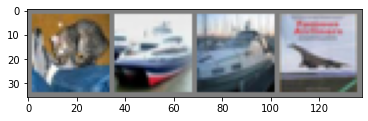

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship truck plane


In [7]:

def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Let's choose a test image at index `ind` and apply some of our attribution algorithms on it.

In [8]:
ind = 1

input = images[ind].unsqueeze(0)
input.requires_grad = True

Sets model to eval mode for interpretation purposes

In [9]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
)

Computes gradients with respect to class `ind` and transposes them for visualization purposes.

In [10]:
saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In the cell below we will visualize the attributions for `Saliency Maps`, `DeepLift`, `Integrated Gradients` and `Integrated Gradients with SmoothGrad`.

Original Image
Predicted: ship  Probability: 0.7750524282455444


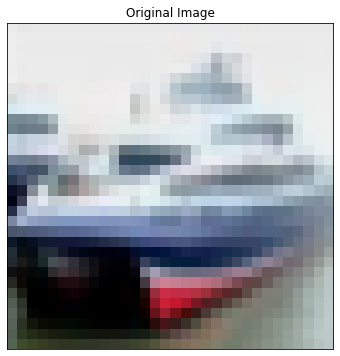

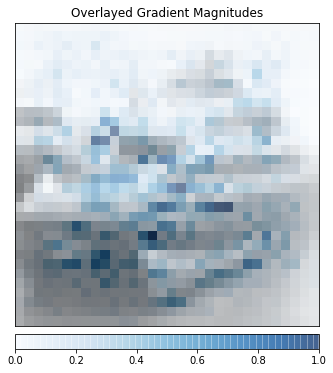

In [11]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

